# TorchVision

In [24]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm

from helper_functions import accuracy_fn

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


## 1. Getting a dataset
Using `FashionMNIST` from torchvision.datasets

In [2]:
## setting up training data:
train_data = datasets.FashionMNIST(
    root="../data/",
    train=True,
    download=True,
    transform=ToTensor(),  # how to transform the data
    target_transform=None
)

## setting up test data:
test_data = datasets.FashionMNIST(
    root="../data/",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[1000]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.3804, 0.3294, 0.3804, 0.4314, 0.4235,
           0.3412, 0.3804, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0745, 1.0000, 0.7804, 0.7176, 0.5569, 0.6314,
           0.7843, 0.8353, 0.1255, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.2824, 0.6824, 0.6784, 0.6196, 0.5137, 0.5176,
           0.6902, 0.6902, 0.2745, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.5569, 0.7059, 0.6392, 0.4706, 0.7059, 0.4941,
           0.5451, 0.6588, 0.4784, 0.0000, 

In [5]:
class_names = train_data.classes  # class attribute: list of classes
class_names


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
print(image.shape)
print(image.size())
print(image.numel())
print(image.dtype)
print(image.device)
print(image.requires_grad)


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
784
torch.float32
cpu
False


## Visualizing the data

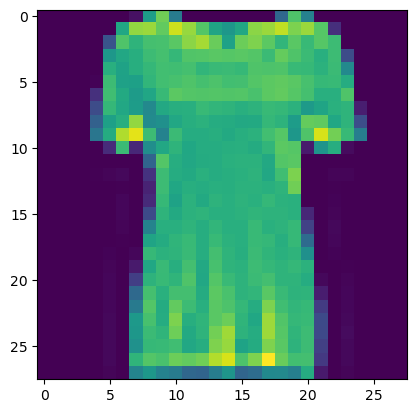

In [7]:
image, label = train_data[10]
plt.imshow(image.squeeze())

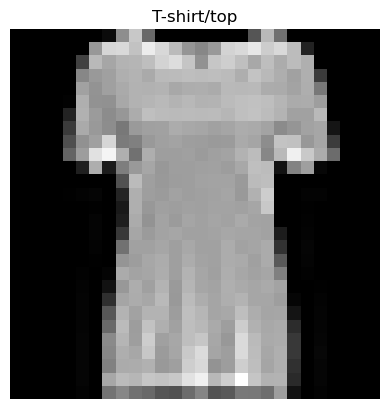

In [8]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis(False);

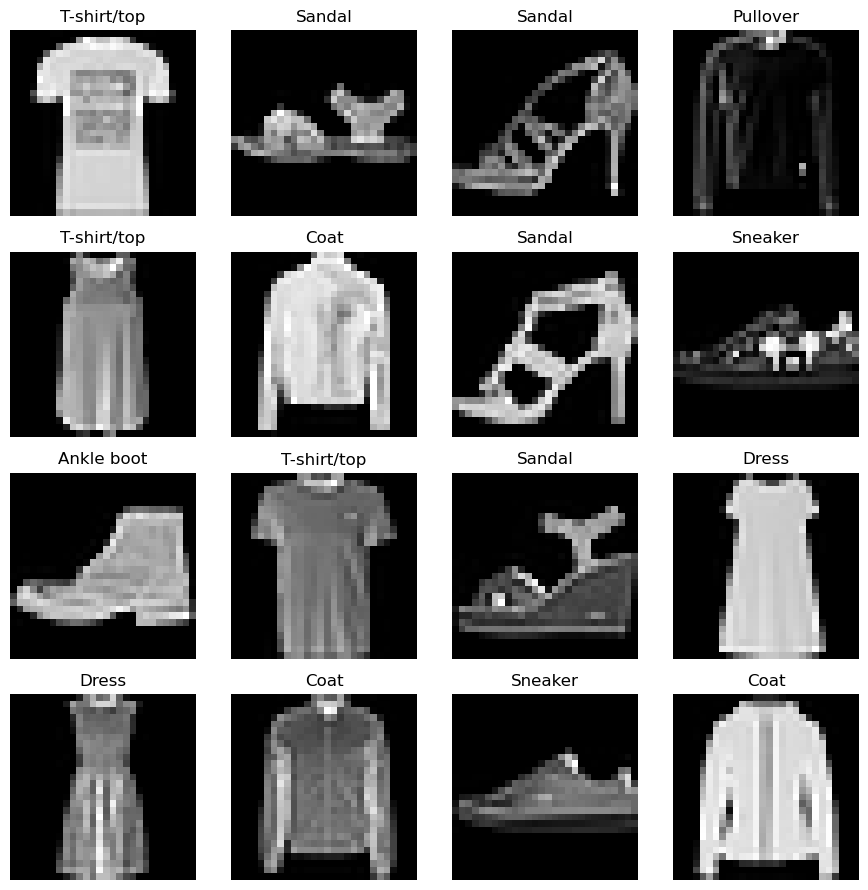

In [9]:
## plotting more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx] 
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);
plt.tight_layout();

In [10]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ../data/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ../data/
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Preparing Dataloader:
Turning PyTorch dataset into a python iterable. More specifically we want to turn our data into batches (or mini-batches) -> computationally more efficient

In [11]:
BATCH_SIZE = 32  # HYPERPARAMETER

train_dataloader = DataLoader(dataset=train_data,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True)
                                   
test_dataloader = DataLoader(dataset=test_data,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")



Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a3929eb9d80>, <torch.utils.data.dataloader.DataLoader object at 0x7a382372c1f0>)
Length of train_dataloader: 1875
Length of test_dataloader: 313


In [12]:
## Check out what's inside the training dataloader:
train_features_batch, train_labels_batch = next(iter(train_dataloader))  # Extract one batch of training data data.
train_features_batch.shape, train_labels_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 3. Building a baseline model:

When starting to build a series of ML modelling experiments, it's a best practice to start with `baseline models`. 

A `baseline model` is a <u>simple model</u> you will try and improve upon with subsequent models/ experiments.

Note: Start simply and add complexity when necessary.

In [25]:
flatten_model = nn.Flatten()  # Creating a flatten layer
x = train_features_batch[10]  # get a single sample
print(f"before flattening: {x.shape}")
output = flatten_model(x)  # flatten the sample
print(f"after flattening: {output.shape}")
output.squeeze()  # remove extra dimensions

before flattening: torch.Size([1, 28, 28])
after flattening: torch.Size([1, 784])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.3176, 0.1922, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
        0.0039, 0.0000, 0.0000, 0.0000, 0.7529, 0.9961, 0.9725, 0.9922, 0.6863,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.4196, 0.8353, 0.7686, 0.8039, 0.8039,
        0.8275, 0.5059, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1333, 0.3216, 0.4157, 0.3294, 0.6471, 0.8824, 0.8667,
        0.8235, 0.7412, 0.3686, 0.3804, 0.3412, 0.1098, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [26]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
                 
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # flatten inputs into vector
            nn.Linear(input_shape, hidden_units),  # first hidden layer
            nn.Linear(hidden_units, output_shape)  # output layer      
            
        )

    def forward(self, x):
        return self.layer_stack(x)
    
baselineModel = FashionMNISTModelV0(input_shape=28*28,
                                    hidden_units=10,
                                    output_shape=len(class_names))
baselineModel.to("cpu")


FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [27]:
dummy_x = torch.rand([1, 1, 28, 28])
dummy_x
baselineModel(dummy_x)

tensor([[-0.0495,  0.5867,  0.7418,  0.0717, -0.1783, -0.5327, -0.0988,  0.2080,
         -0.3145,  0.4249]], grad_fn=<AddmmBackward0>)

In [16]:
loss_fn = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = torch.optim.SGD(params=baselineModel.parameters(),
                            lr=0.1)

In [17]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


### Creating a training loop and training a model on batches of data:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print out what's happening.
5. Time it all.

`Highlight:` the optimizer will update a model's parameters once per batch rather than once per epochs (whole 60k images)

In [28]:
## Training loop:
torch.manual_seed(42)
train_time_start_on_cpu = timer()


epochs = 3  # TODO

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss = 0
    # Model parameters are being updated after each batch:
    for batch, (x, y) in enumerate(train_dataloader):
        baselineModel.eval()
        y_pred = baselineModel(x)  # forward pass

        loss = loss_fn(y_pred, y)  # calculate loss
        train_loss += loss  # accumulate loss

        optimizer.zero_grad()  # optimizer zero grad
        loss.backward()  # backpropagation
        optimizer.step()  # gradient descent
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples")
            
    train_loss /= len(train_dataloader)

    ## Testing loop:
    test_loss, test_acc = 0, 0

    # Put model in evaluation mode and disable gradient calculation:
    baselineModel.eval()
    with torch.inference_mode():
        for x_test, y_test in test_dataloader:
            test_pred = baselineModel(x_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test,
                                    y_pred=test_pred.argmax(dim=1))    


train_time_end_on_cpu = timer()
print_train_time(train_time_start_on_cpu,
                 train_time_end_on_cpu,
                 device=str(next(baselineModel.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:05<00:11,  5.52s/it]

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:13<00:06,  6.78s/it]

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:19<00:00,  6.51s/it]

Train time on cpu: 19.536 seconds


19.535879937000573

In [30]:
str(next(baselineModel.parameters()).device)

'cpu'

### Making predictions and get a result from baselineModel:

In [20]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device=None):
    
    """ Return a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            y_pred = baselineModel(x)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

model_results = eval_model(model=baselineModel,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device=str(next(baselineModel.parameters()).device))

model_results

100%|██████████| 313/313 [00:01<00:00, 301.53it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4770145118236542,
 'model_acc': 83.48642172523962}

### Setup device-agnostic code

In [21]:
torch.cuda.is_available()

True

# 4. Improving the model by adding <u>nonlinearity</u> and running on <u>GPU</u>:

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
import torch, sys
print("torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version (wheel):", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU 0:", torch.cuda.get_device_name(0))

torch: 2.6.0+cu124
CUDA available: True
CUDA version (wheel): 12.4
GPU count: 1
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU


In [34]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
                 
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

In [37]:
## Create an instance of the model and send it to the target device (either GPU or CPU):
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### Functionizing trainin and testing/evaluation codes: